In [1]:
import sys 
sys.path.append("/scratch/m/murray/dtolgay")
from tools import constants

import numpy as np 
import pandas as pd 


base_dir = "/home/m/murray/dtolgay/scratch/cloudy_runs/z_0/cr_1_CO87_CII_H_O3/cr_1_CO87_CII_H_O3_metallicity_above_minus_2"

import matplotlib.pyplot as plt 

# Functions

In [2]:
def find_converged_run(cloudy_em_str: np.ndarray, threshold: float = 0) -> np.ndarray:
    """
    To use the coverged value, I will look at the radius values in the file. If radius decreases to initial radius and simulations
    ran one more time starting from the beginning then it means that in the first run it is not coverged and simulation was run again
    Second run gives the converged value. Use the second run.
    """

    index = 0
    for i in range(len(cloudy_em_str) - 1):
        if (cloudy_em_str[i][0] - cloudy_em_str[i + 1][0]) > threshold:
            index = i + 1

    cloudy_em_str = cloudy_em_str[index:]

    return cloudy_em_str


def read_emissivity_file(base_dir, file_props):
    
    emissivity_columns = [
        "depth",
        "lya",    # [erg/cm3/s]
        "ha",
        "hb",
        "co_10",
        "co_21",
        "co_32",
        "co_43",
        "co_54",
        "co_65",
        "co_76",
        "co_87",
        "13co",
        "c2",
        "o3_88", 
        "o3_5006", 
        "o3_4958",    
    ]    
    
    fname = f"hden{file_props['log_hden']:.5f}_metallicity{file_props['log_metallicity']:.5f}_turbulence{file_props['log_turbulence']:.5f}_isrf{file_props['log_isrf']:.5f}_radius{file_props['log_radius']:.5f}"
    
    emissivity_file = np.loadtxt(f"{base_dir}/{fname}/{fname}_em.str")
    emissivity_file = find_converged_run(emissivity_file)
    emissivity_file = pd.DataFrame(emissivity_file, columns=emissivity_columns)
    emissivity_file['column_density'] = emissivity_file['depth'] * (10**file_props['log_hden'] * constants.proton_mass * constants.kg2g) # g / cm2    
    
    return emissivity_file

# Main

In [3]:
center_columns = ["metallicity", "hden", "turbulence", "isrf", "radius"]
flux_columns = [
    "lya", # [erg s^-1 cm^-2]
    "ha", # [erg s^-1 cm^-2]
    "hb", # [erg s^-1 cm^-2]
    "co_10", # [erg s^-1 cm^-2]
    "co_21", # [erg s^-1 cm^-2]
    "co_32", # [erg s^-1 cm^-2]
    "co_43", # [erg s^-1 cm^-2]
    "co_54", # [erg s^-1 cm^-2]
    "co_65", # [erg s^-1 cm^-2]
    "co_76", # [erg s^-1 cm^-2]
    "co_87", # [erg s^-1 cm^-2]
    "13co", # [erg s^-1 cm^-2]
    "c2", # [erg s^-1 cm^-2]
    "o3_88", # [erg s^-1 cm^-2]
    "o3_5006", # [erg s^-1 cm^-2]
    "o3_4958", # [erg s^-1 cm^-2]    
]
flux_columns = center_columns + flux_columns


line_fluxes = pd.DataFrame(
    np.loadtxt(f"{base_dir}/I_line_values_without_reversing.txt"),
    columns = flux_columns
)

In [4]:
for column in center_columns:
    print(f"{column}: {line_fluxes[column].unique()}")


metallicity: [-2.  -1.5 -1.  -0.5  0.   0.5  1. ]
hden: [-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]
turbulence: [-3. -2. -1.  0.  1.  2.  3.]
isrf: [-5.  -4.5 -4.  -3.5 -3.  -2.5 -2.  -1.5 -1.  -0.5  0.   0.5  1.   1.5
  2.   2.5  3.   3.5  4.   4.5  5. ]
radius: [0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]


In [28]:
file_props_1 = {
    "log_hden": 2,
    "log_metallicity": 1,
    "log_turbulence": 1,
    "log_isrf": -1,
    "log_radius": 2,
}
low_hden = read_emissivity_file(base_dir, file_props=file_props_1)


file_props_2 = {
    "log_hden": 2,
    "log_metallicity": 1,
    "log_turbulence": 1,
    "log_isrf": -2,
    "log_radius": 2,
}
high_hden = read_emissivity_file(base_dir, file_props=file_props_2)



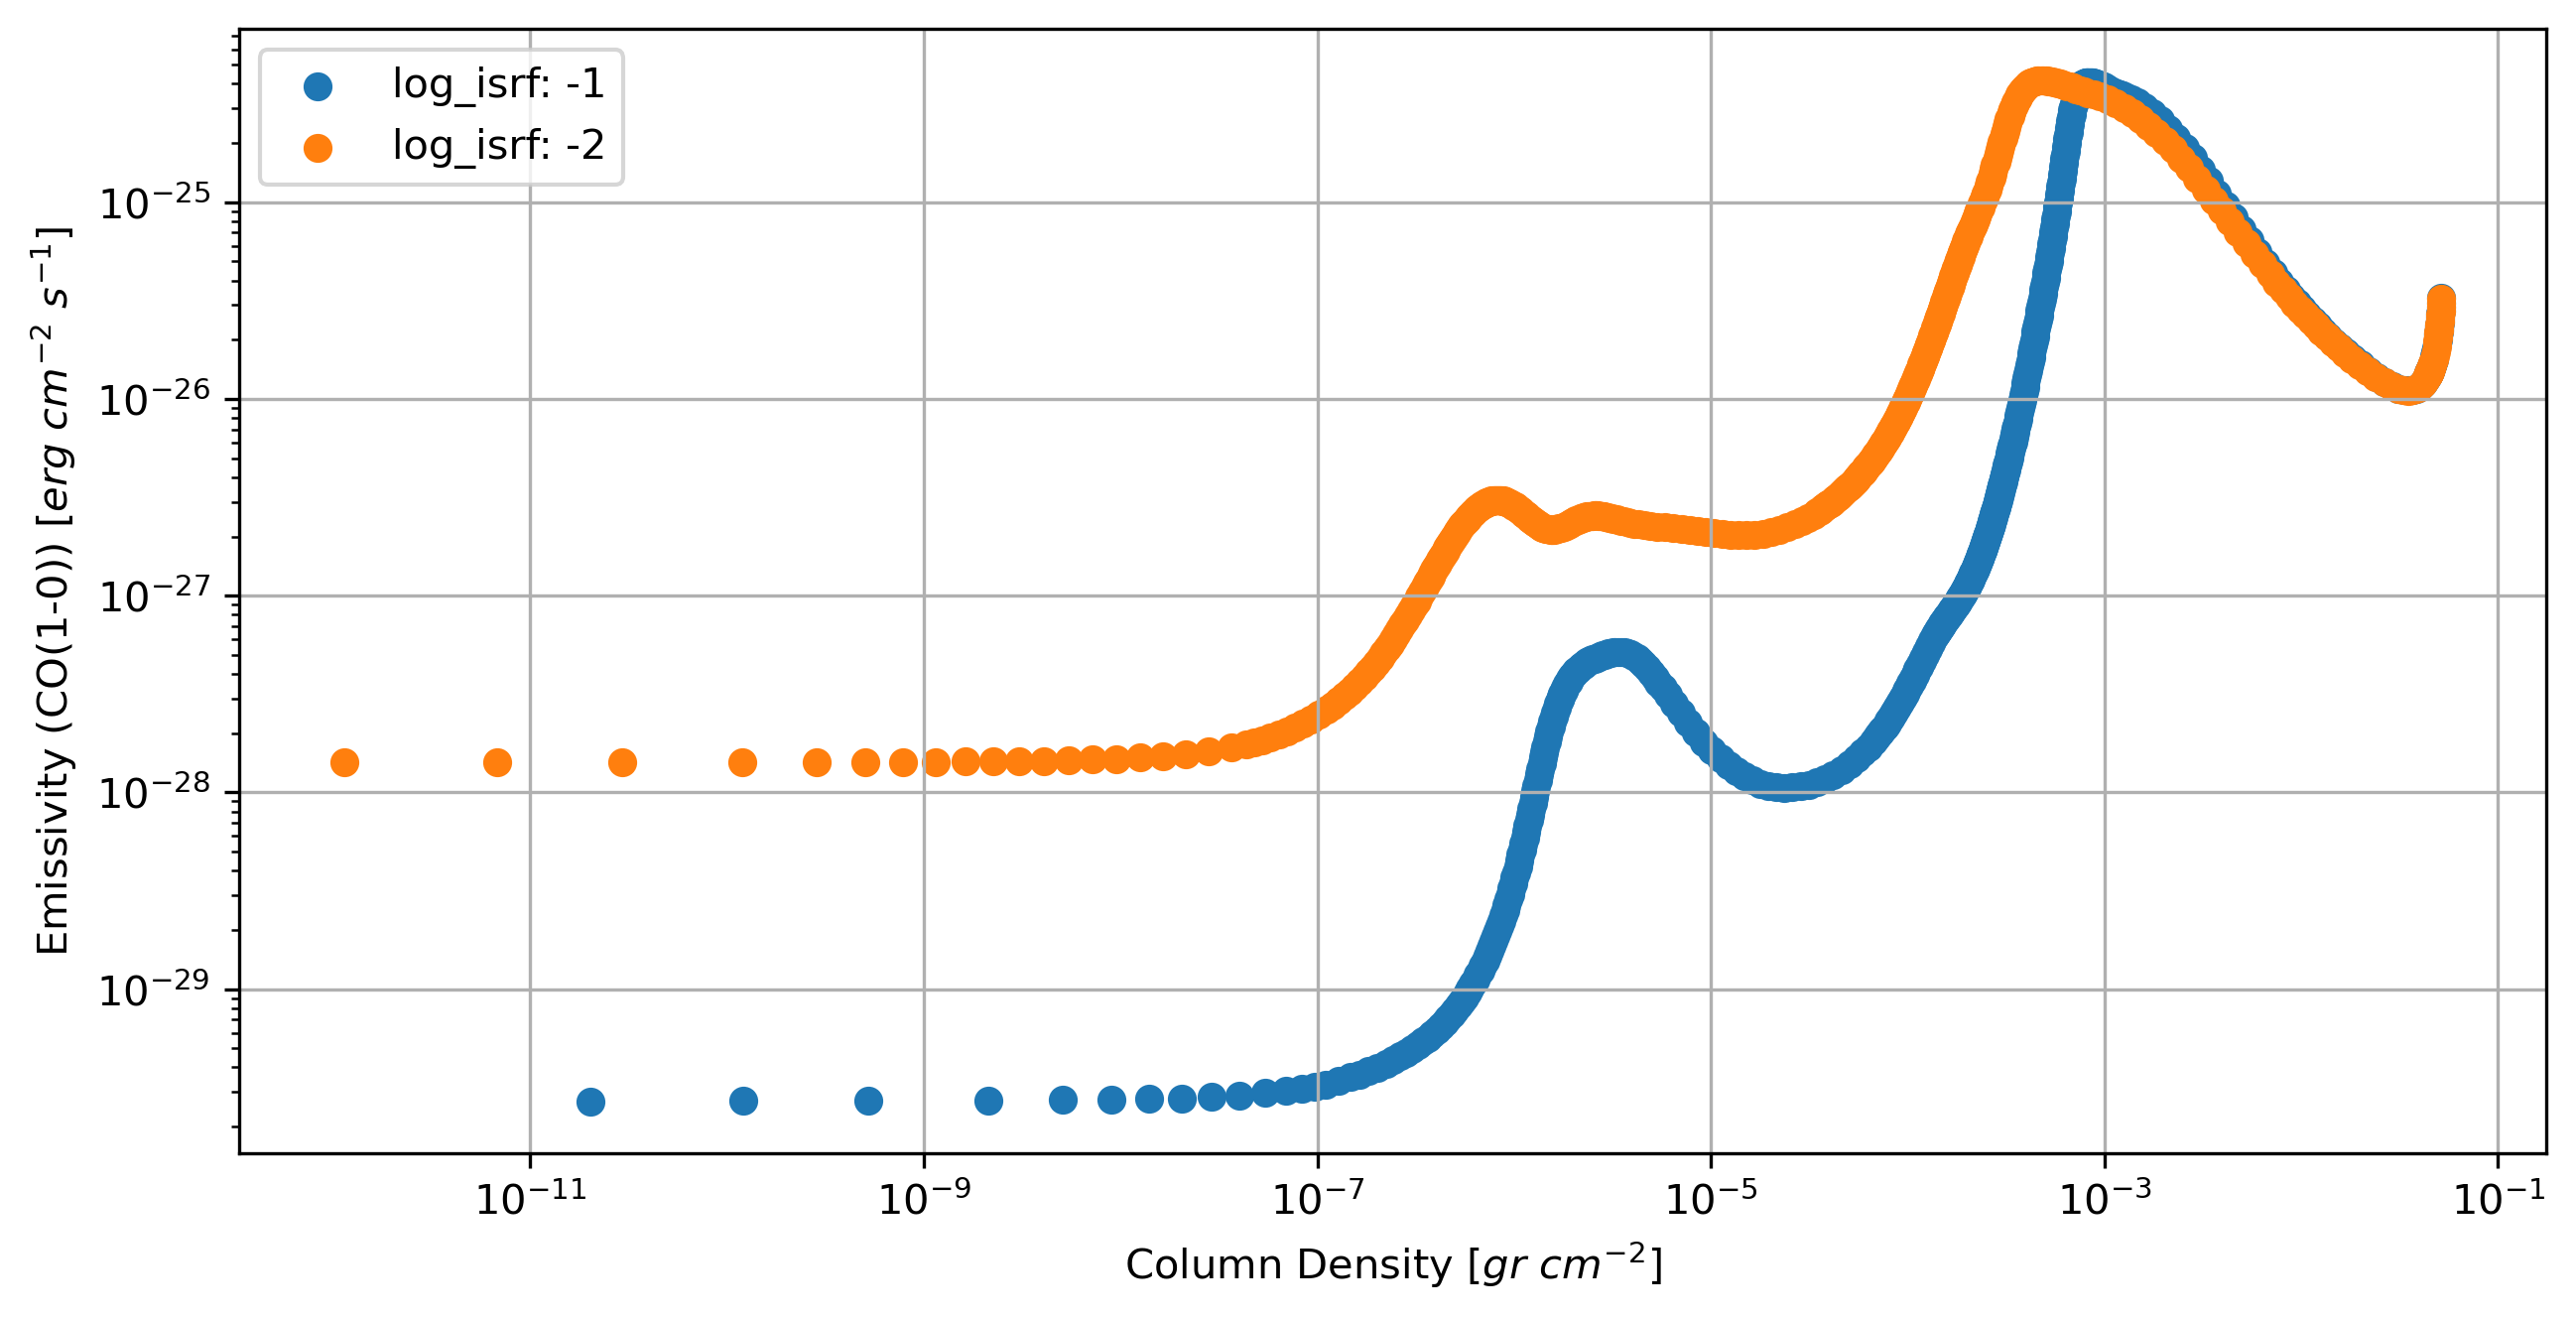

In [29]:
plt.figure(figsize=(10,5), dpi=300)
plt.scatter(low_hden['column_density'], low_hden['co_10'], label=f"log_isrf: {file_props_1['log_isrf']}")
plt.scatter(high_hden['column_density'], high_hden['co_10'], label=f"log_isrf: {file_props_2['log_isrf']}")

plt.xlabel(r"Column Density [$gr$ $cm^{-2}$]")
plt.ylabel(r"Emissivity (CO(1-0)) [$erg$ $cm^{-2}$ $s^{-1}$]")

plt.xscale("log")
plt.yscale("log")
plt.grid(True)
plt.legend(loc="upper left")

plt.show()

In [30]:
# Print the calculated flux values
def find_indices_of_the_run(line_fluxes, file_props):
    index = np.where(
        (line_fluxes['hden'] == np.round(file_props['log_hden'], 1)) &
        (line_fluxes['metallicity'] == np.round(file_props['log_metallicity'], 1)) &
        (line_fluxes['turbulence'] == np.round(file_props['log_turbulence'], 1)) &
        (line_fluxes['isrf'] == np.round(file_props['log_isrf'], 1)) &
        (line_fluxes['radius'] == np.round(file_props['log_radius'], 1))
    )[0]
    
    return index

index1 = find_indices_of_the_run(line_fluxes, file_props=file_props_1)
index2 = find_indices_of_the_run(line_fluxes, file_props=file_props_2)

print(f"{line_fluxes.iloc[index1][['hden', 'metallicity', 'turbulence', 'isrf', 'radius', 'co_10']]}")
print(f"{line_fluxes.iloc[index2][['hden', 'metallicity', 'turbulence', 'isrf', 'radius', 'co_10']]}")

line_fluxes.iloc[index1]['co_10'].values - line_fluxes.iloc[index2]['co_10'].values

        hden  metallicity  turbulence  isrf  radius    co_10
119057   2.0          1.0         1.0  -1.0     2.0  0.00001
        hden  metallicity  turbulence  isrf  radius    co_10
119035   2.0          1.0         1.0  -2.0     2.0  0.00001


array([5.3676e-09])